# Udacity Advanced Lane Finding Project

## Imports

In [300]:
import numpy as np
import cv2
import glob
import pickle
import math
from ipywidgets import interact
from moviepy.editor import VideoFileClip
import matplotlib.pyplot as plt
%matplotlib inline

print('done')

done


## Camera calibration

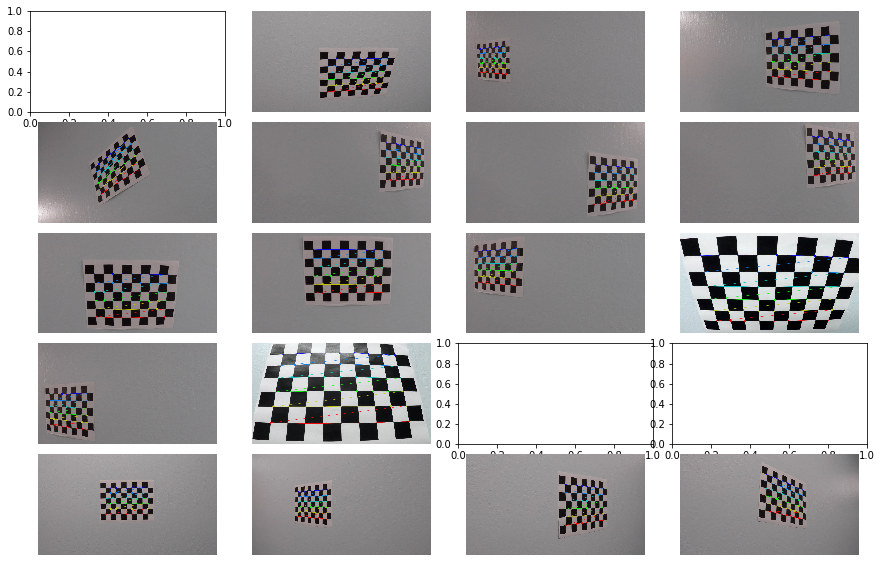

In [393]:
# reference: https://docs.opencv.org/3.3.1/dc/dbb/tutorial_py_calibration.html

# prepare object points
nx = 9
ny = 6

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

# get the provided calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# prepare figure for plotting the results
figure, axis = plt.subplots(5, 4, figsize=(15, 10))
figure.subplots_adjust(hspace=0.1, wspace=0.1)
axis = axis.ravel()

for i, fname in enumerate(images):
    image = cv2.imread(fname)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        
        corners2=cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners)
        
        # Draw and display the corners
        cv2.drawChessboardCorners(image, (nx,ny), corners2, ret)
        axis[i].axis('off')
        axis[i].imshow(image)

figure.savefig('chessBoard.png')

In [21]:
# calibrate the camera
image = cv2.imread('./camera_cal/calibration1.jpg')
ret, cameraMatrix, distCoeffs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (image.shape[1], image.shape[0]), None, None)

# save the calibration matrix so we don't have to calibrate every time.
with open('calib.p', 'wb') as f:
    pickle.dump({'cameraMatrix': cameraMatrix, 'distCoeffs': distCoeffs}, f)


In [22]:
# load the calibration
with open('calib.p', 'rb') as f:
    data = pickle.load(f)

cameraMatrix = data['cameraMatrix']
distCoeffs = data['distCoeffs']

In [395]:
def plotImages(images, titles, cmap=False):
    '''
    Plots the images and the assosiated titles
    '''

    def closestDivisors(n):
        a = round(math.sqrt(n))
        while n%a > 0: a -= 1
        return a,n//a
    
    # prepare figure for plotting the results
    size = closestDivisors(len(images))
    figure, axis = plt.subplots(size[0], size[1], figsize=(15, 10))
    figure.subplots_adjust(hspace=0.1, wspace=0.1)
    axis = axis.ravel()
    
    for i in range(len(images)):
        if cmap:
            axis[i].imshow(images[i], cmap=cmap)
        else:
            axis[i].imshow(images[i])
        axis[i].set_title(titles[i])
        axis[i].axis('off')
    

## Get a test image to develop the pipeline with

(-0.5, 1279.5, 719.5, -0.5)

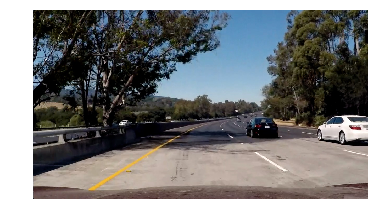

In [156]:
testImage = cv2.imread('./test_images/test5.jpg')
testImage = cv2.cvtColor(testImage, cv2.COLOR_BGR2RGB)
plt.imshow(testImage)
plt.axis('off')

## Define functions for the pipeline

### Undistort 
Undistort the image using the calibration matrix

In [157]:
def undistort(image, cameraMatrix, distCoeffs):
    '''
    Undistors image using calibration matrix cameraMatrix and distortion coefficient distCoeffs.
    '''
    
    return cv2.undistort(image, cameraMatrix, distCoeffs, None, cameraMatrix)

Demostrate undestortion on the test image

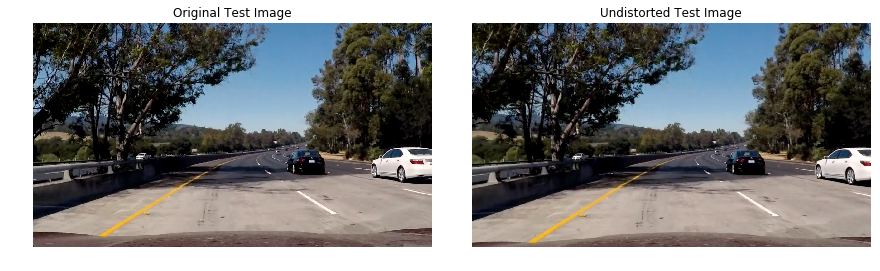

In [367]:
testImageUndistort = undistort(testImage, cameraMatrix, distCoeffs)

plotImages([testImage, testImageUndistort], ['Original Test Image', 'Undistorted Test Image'])

### Perspective Transform
Unwrap the image to get top view perspective.

In [359]:
def unwrap(image):
    '''
    Returns unwrapped image as well as prespective matrix on a defined trapezoid below.
    '''
    
    # define the trapezoid
    h, w = image.shape[:2]
    upper = int(0.05*w)
    lower = int(0.3*w)
    height = int(0.315*h)
    bottomMargin = int(0.05*h)
    offset = int((1/3)*w)
    source = np.float32([(w//2-upper, h-height-bottomMargin),
                        (w//2+upper, h-height-bottomMargin),
                        (w//2+lower, h-bottomMargin),
                        (w//2-lower, h-bottomMargin)])
    dest = np.float32([(offset, 0),
                      (w-offset, 0),
                      (w-offset, h),
                      (offset, h)])
    
    M = cv2.getPerspectiveTransform(source, dest)
    Minv = cv2.getPerspectiveTransform(dest, source)
    warped = cv2.warpPerspective(image, M, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)
    return warped, M, Minv

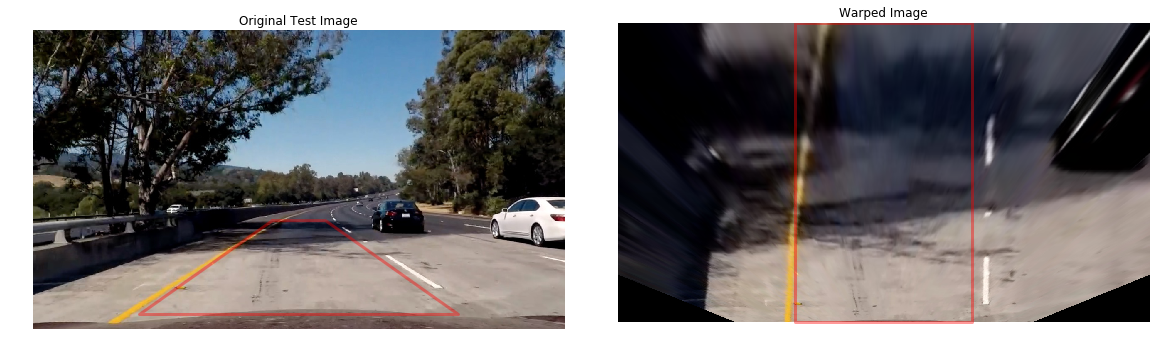

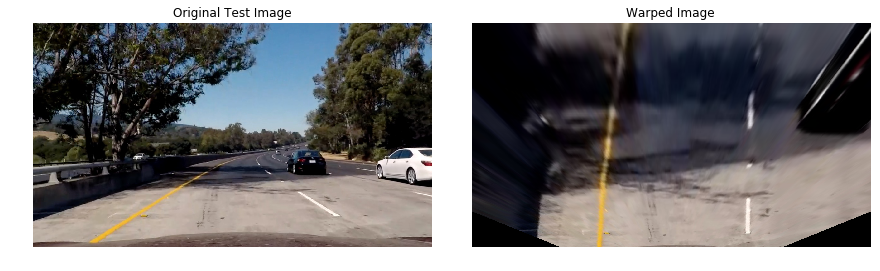

In [365]:
# define the trapezoid
h, w = testImageUndistort.shape[:2]
upper = int(0.05*w)
lower = int(0.3*w)
height = int(0.315*h)
bottomMargin = int(0.05*h)
offset = int((1/3)*w)
source = np.float32([(w//2-upper, h-height-bottomMargin),
                    (w//2+upper, h-height-bottomMargin),
                    (w//2+lower, h-bottomMargin),
                    (w//2-lower, h-bottomMargin)])
dest = np.float32([(offset, 0),
                  (w-offset, 0),
                  (w-offset, h),
                  (offset, h)])

testImageUnwrap, M, Minv = unwrap(testImageUndistort)

# plot the trapezoid
xSrc = [source[0][0], source[1][0], source[2][0], source[3][0], source[0][0]]
ySrc = [source[0][1], source[1][1], source[2][1], source[3][1], source[0][1]]
xDest = [dest[0][0], dest[1][0], dest[2][0], dest[3][0], dest[0][0]]
yDest = [dest[0][1], dest[1][1], dest[2][1], dest[3][1], dest[0][1]]

figure, axis = plt.subplots(1, 2, figsize=(20, 10))
figure.subplots_adjust(hspace=0.1, wspace=0.1)
axis = axis.ravel()

axis[0].imshow(testImageUndistort)
axis[0].plot(xSrc, ySrc, color='red', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
axis[0].set_title('Original Test Image')
axis[0].axis('off')

axis[1].imshow(testImageUnwrap)
axis[1].plot(xDest, yDest, color='red', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
axis[1].set_title('Warped Image')
axis[1].axis('off')

figure.savefig('unwrap.png')

plotImages([testImageUndistort, testImageUnwrap], ['Original Test Image', 'Warped Image'])

### Plot different colour 
Plot different chanels from different colour spaces to see which works best ofr lane detection.

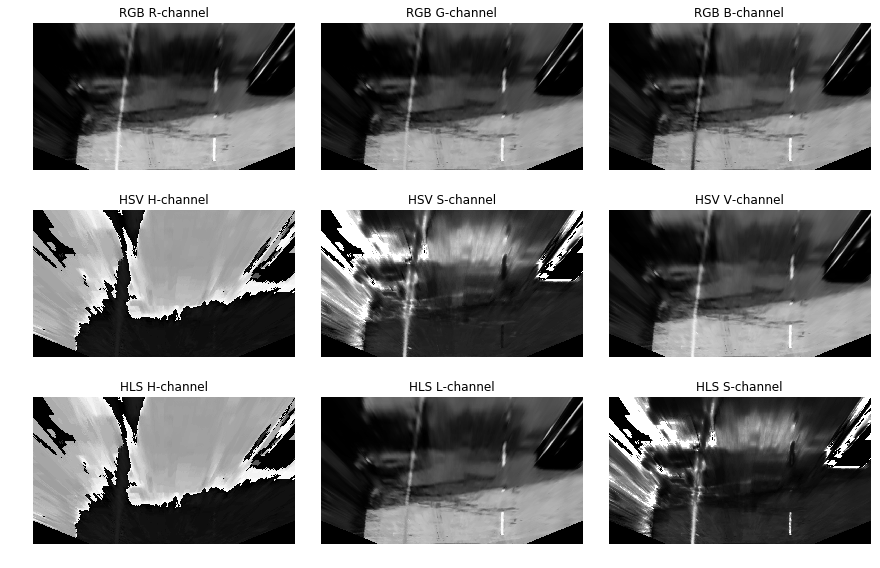

In [161]:
images = []
titles = []

images.append(testImageUnwrap[:,:,0])
images.append(testImageUnwrap[:,:,1])
images.append(testImageUnwrap[:,:,2])
titles.append('RGB R-channel')
titles.append('RGB G-channel')
titles.append('RGB B-channel')

testImageUnwrapHSV = cv2.cvtColor(testImageUnwrap, cv2.COLOR_RGB2HSV)
images.append(testImageUnwrapHSV[:,:,0])
images.append(testImageUnwrapHSV[:,:,1])
images.append(testImageUnwrapHSV[:,:,2])
titles.append('HSV H-channel')
titles.append('HSV S-channel')
titles.append('HSV V-channel')

testImageUnwrapHLS = cv2.cvtColor(testImageUnwrap, cv2.COLOR_RGB2HLS)
images.append(testImageUnwrapHLS[:,:,0])
images.append(testImageUnwrapHLS[:,:,1])
images.append(testImageUnwrapHLS[:,:,2])
titles.append('HLS H-channel')
titles.append('HLS L-channel')
titles.append('HLS S-channel')

plotImages(images, titles, cmap='gray')

### Sobel gradient
Compute sobel gradient along specified axis

In [190]:
def regionOfInterest(image):
    
    imshape = image.shape
    por = 0.25
    vertices = np.array(
        [
            [(int(por*imshape[1]),0),
             (int(imshape[1]*(1-por)), 0),
             (int(imshape[1]*(1-por)), imshape[0]), 
             (int(por*imshape[1]),imshape[0])]
        ], dtype=np.int32)
    
    mask = np.zeros_like(image)   
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(image.shape) > 2:
        channelCount = image.shape[2]  # i.e. 3 or 4 depending on your image
        ignoreMaskColour = (255,) * channelCount
    else:
        ignoreMaskColour = 255

    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignoreMaskColour)

    #returning the image only where mask pixels are nonzero
    maskedImage = cv2.bitwise_and(image, mask)
    return maskedImage

#### Sobel Threshold

In [191]:
def absSobelThresh(image, orient='x', threshMin=0, threshMax=255):
    '''
    Returns image after applying Sobel x or y, then taking an absolute value and applying a threshold.
    '''
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobel = cv2.Sobel(gray, cv2.CV_64F, int(orient=='x'), int(orient=='y'))
    absSobel = np.absolute(sobel)
    scaledSobel = np.uint8(255*absSobel/np.max(absSobel))
    sbinary = np.zeros_like(scaledSobel)
    sbinary[(scaledSobel >= threshMin) & (scaledSobel <= threshMax)] = 1
    sbinary = regionOfInterest(sbinary)
    return sbinary

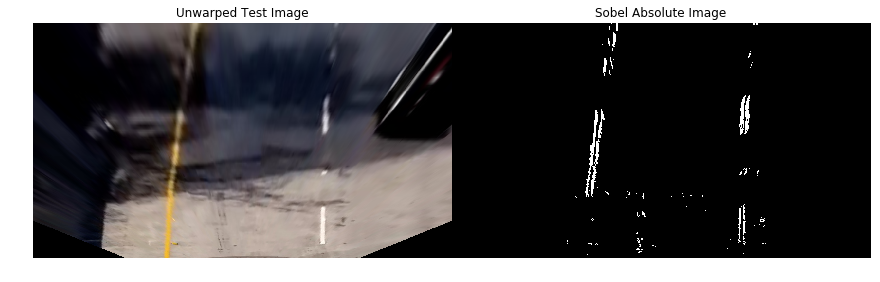

In [371]:
def apply(threshMin, threshMax):
    
    testImageUnwrapSobelThresh = absSobelThresh(testImageUnwrap, 'x', threshMin, threshMax)
    plotImages([testImageUnwrap, testImageUnwrapSobelThresh], ['Unwarped Test Image', 'Sobel Absolute Image'], cmap='gray')
    
# interact(apply, threshMin=(0,225), threshMax=(0,225))
apply(29, 104)

#### Magnitude Sobel Threshold

In [193]:
def magSobelThresh(image, sobelKernel=3, magThresh=(0, 255)):
    '''
    Returns image after applying Sobel x or y, then computes the magnitude of the gradient.
    '''
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobelKernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobelKernel)
    gradMag = np.sqrt(sobelx**2 + sobely**2)
    scaledSobel = np.uint8(255*gradMag/np.max(gradMag))
    threshMin = magThresh[0]
    threshMax = magThresh[1]
    binaryOutput = np.zeros_like(scaledSobel)
    binaryOutput[(scaledSobel >= threshMin) & (scaledSobel <= threshMax)] = 1
    binaryOutput = regionOfInterest(binaryOutput)
    return binaryOutput

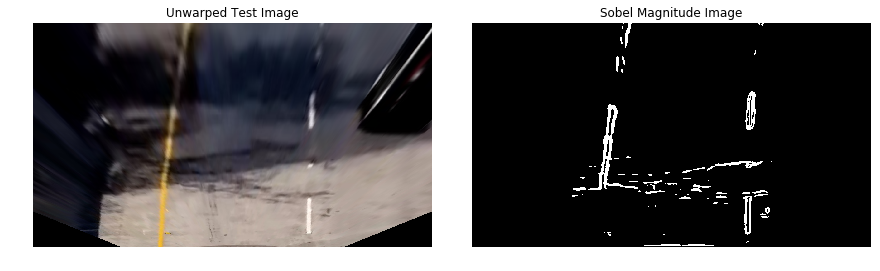

In [373]:
def apply2(sobelKernel, threshMin, threshMax):
    
    testImageUnwrapSobelThresh = magSobelThresh(testImageUnwrap, sobelKernel, (threshMin, threshMax))
    plotImages([testImageUnwrap, testImageUnwrapSobelThresh], ['Unwarped Test Image', 'Sobel Magnitude Image'], cmap='gray')
    

# interact(apply2, sobelKernel=(1,31,2), threshMin=(0,225), threshMax=(0,225))
apply2(31, 40, 115)

#### Direction Sobel Threshold

In [195]:
def dirSobelThresh(image, sobelKernel=3, magThresh=(0, np.pi/2)):
    '''
    Returns image after applying Sobel x or y, then computes the direction of the gradient.
    '''
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobelKernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobelKernel)
    absSobelX = np.absolute(sobelx)
    absSobelY = np.absolute(sobely)
    scaledSobel = np.arctan2(absSobelY, absSobelX)
    threshMin = magThresh[0]
    threshMax = magThresh[1]
    binaryOutput = np.zeros_like(scaledSobel)
    binaryOutput[(scaledSobel >= threshMin) & (scaledSobel <= threshMax)] = 1
    binaryOutput = regionOfInterest(binaryOutput)
    return binaryOutput

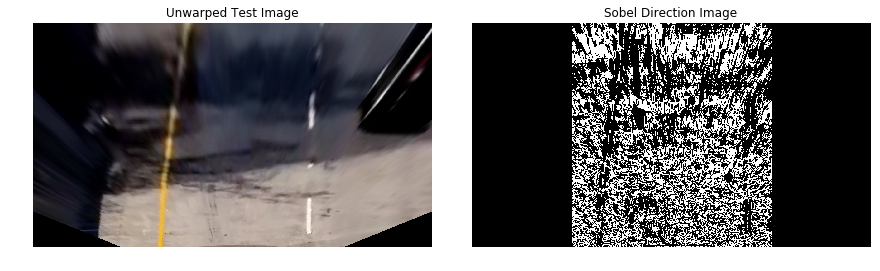

In [375]:
def apply3(sobelKernel, threshMin, threshMax):
    
    testImageUnwrapSobelThresh = dirSobelThresh(testImageUnwrap, sobelKernel, (threshMin, threshMax))
    plotImages([testImageUnwrap, testImageUnwrapSobelThresh], ['Unwarped Test Image', 'Sobel Direction Image'], cmap='gray')
    

# interact(apply3, sobelKernel=(1,31,2), threshMin=(0,np.pi/2,0.01), threshMax=(0,np.pi/2,0.01))
apply3(9, 0.72, 1.41)

#### Direction and Magnitude Sobel Threshold

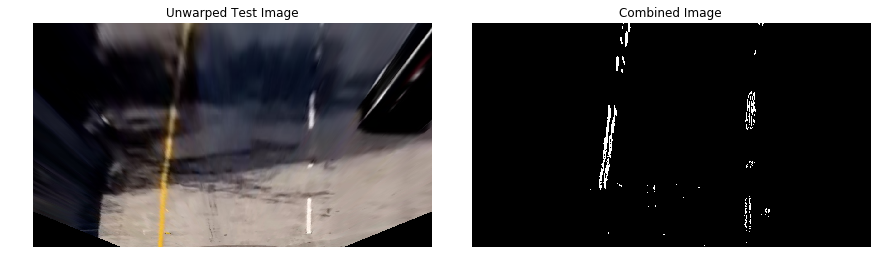

In [376]:
def apply4(absThreshMin, absThreshMax, magSobelKernel, magThreshMin, magThreshMax, dirSobelKernel, dirThreshMin, dirThreshMax):
    gradx = absSobelThresh(testImageUnwrap, 'x', absThreshMin, absThreshMax)
    grady = absSobelThresh(testImageUnwrap, 'y', absThreshMin, absThreshMax)
    magBinary = magSobelThresh(testImageUnwrap, magSobelKernel, (magThreshMin, magThreshMax))
    dirBinary = dirSobelThresh(testImageUnwrap, dirSobelKernel, (dirThreshMin, dirThreshMax))
    
    combined = np.zeros_like(dirBinary)
    combined[(gradx == 1) & (magBinary == 1)] = 1
    
    plotImages([testImageUnwrap, combined], ['Unwarped Test Image', 'Combined Image'], cmap='gray')
    
# interact(apply4, 
#          absThreshMin=(0,225), absThreshMax=(0,225), 
#          magSobelKernel=(1,31,2), magThreshMin=(0,225), magThreshMax=(0,225),
#          dirSobelKernel=(1,31,2), dirThreshMin=(0,np.pi/2,0.01), dirThreshMax=(0,np.pi/2,0.01))
apply4(24, 66, 31, 40, 115, 21, 0, 1.48)

### HLS channels Threshold

#### S-chanel Threshold

In [198]:
def HLS_SThresh(image, thresh=(0, 225)):
    '''
    Define a function that thresholds the S-channel of HLS.
    '''
    
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    binaryOutput = np.zeros_like(S)
    binaryOutput[(S > thresh[0]) & (S <= thresh[1])] = 1
    return binaryOutput

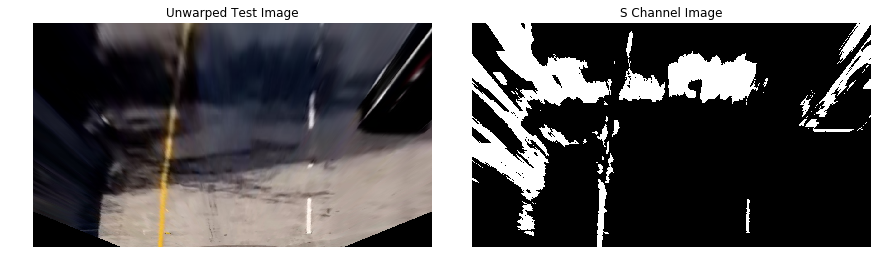

In [394]:
def apply5(threshMin, threshMax):
    
    testImageUnwrapSThresh = HLS_SThresh(testImageUnwrap, (threshMin, threshMax))
    plotImages([testImageUnwrap, testImageUnwrapSThresh], ['Unwarped Test Image', 'S Channel Image'], cmap='gray')
    
# interact(apply5, threshMin=(0,255), threshMax=(0,255))
apply5(113, 255)
# hls = cv2.cvtColor(testImageUnwrap, cv2.COLOR_RGB2HLS)
# S = hls[:,:,2]
# plotImages([testImageUnwrap, S], ['Unwarped Test Image', 'S Channel Image'], cmap='gray')

H-channel Thershold

In [200]:
def HLS_HThresh(image, thresh=(0, 225)):
    '''
    Define a function that thresholds the H-channel of HLS.
    '''
    
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    binaryOutput = np.zeros_like(H)
    binaryOutput[(H > thresh[0]) & (H <= thresh[1])] = 1
    return binaryOutput

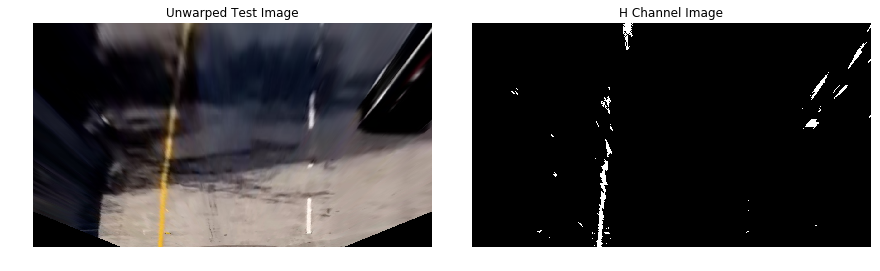

In [378]:
def apply6(threshMin, threshMax):
    
    testImageUnwrapHThresh = HLS_HThresh(testImageUnwrap, (threshMin, threshMax))
    plotImages([testImageUnwrap, testImageUnwrapHThresh], ['Unwarped Test Image', 'H Channel Image'], cmap='gray')
    
# interact(apply6, threshMin=(0,255), threshMax=(0,255))
apply6(19, 90)

#### L-channel Threshold

In [203]:
def HLS_LThresh(image, thresh=(0, 225)):
    '''
    Define a function that thresholds the H-channel of HLS.
    '''
    
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    L = hls[:,:,1]
    L = L*(255/np.max(L))
    binaryOutput = np.zeros_like(L)
    binaryOutput[(L > thresh[0]) & (L <= thresh[1])] = 1
    return binaryOutput

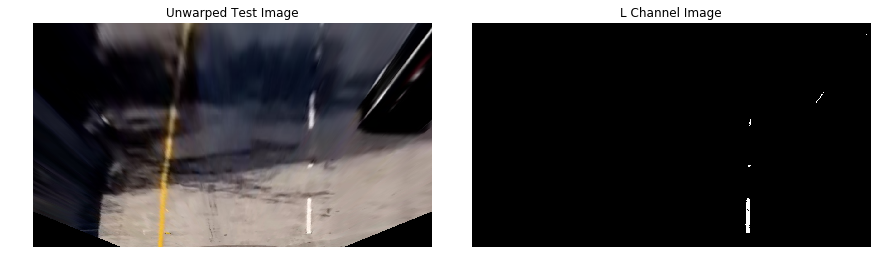

In [379]:
def apply7(threshMin, threshMax):
    
    testImageUnwrapLThresh = HLS_LThresh(testImageUnwrap, (threshMin, threshMax))
    plotImages([testImageUnwrap, testImageUnwrapLThresh], ['Unwarped Test Image', 'L Channel Image'], cmap='gray')
    
# interact(apply7, threshMin=(0,255), threshMax=(0,255))
apply7(220, 255)

### RGB Channels Thershold

#### R-channel Threshold

In [205]:
def RGB_RThresh(image, thresh=(0, 225)):
    '''
    Define a function that thresholds the R-channel of RGB.
    '''
    
    R = image[:,:,0]
    binaryOutput = np.zeros_like(R)
    binaryOutput[(R > thresh[0]) & (R <= thresh[1])] = 1
    return binaryOutput

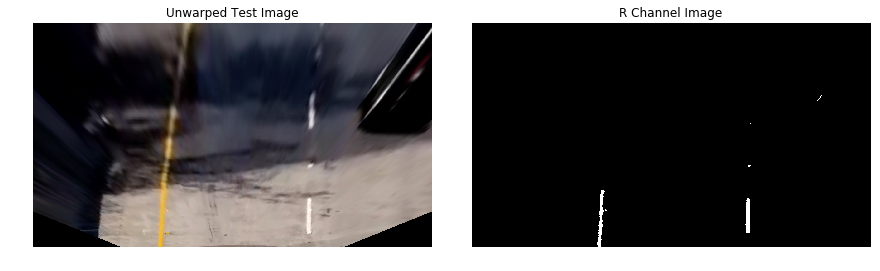

In [380]:
def apply8(threshMin, threshMax):
    
    testImageUnwrapRThresh = RGB_RThresh(testImageUnwrap, (threshMin, threshMax))
    plotImages([testImageUnwrap, testImageUnwrapRThresh], ['Unwarped Test Image', 'R Channel Image'], cmap='gray')
    
# interact(apply8, threshMin=(0,255), threshMax=(0,255))
apply8(223, 255)

# plotImages([testImageUnwrap, testImageUnwrap[:,:,0]], ['Unwarped Test Image', 'R Channel Image'], cmap='gray')

#### G-channel Threshold 

In [207]:
def RGB_GThresh(image, thresh=(0, 225)):
    '''
    Define a function that thresholds the G-channel of RGB.
    '''
    
    G = image[:,:,1]
    binaryOutput = np.zeros_like(G)
    binaryOutput[(G > thresh[0]) & (G <= thresh[1])] = 1
    return binaryOutput

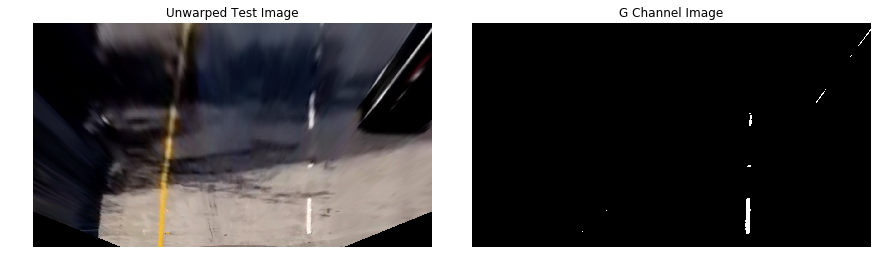

In [381]:
def apply9(threshMin, threshMax):
    
    testImageUnwrapGThresh = RGB_GThresh(testImageUnwrap, (threshMin, threshMax))
    plotImages([testImageUnwrap, testImageUnwrapGThresh], ['Unwarped Test Image', 'G Channel Image'], cmap='gray')
    
# interact(apply9, threshMin=(0,255), threshMax=(0,255))
apply9(199, 255)

# plotImages([testImageUnwrap, testImageUnwrap[:,:,1]], ['Unwarped Test Image', 'G Channel Image'], cmap='gray')

### Gray Threshold

In [209]:
def grayThresh(image, thresh=(0, 225)):
    '''
    Define a function that thresholds the Gray scale.
    '''
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    binary = np.zeros_like(gray)
    binary[(gray > thresh[0]) & (gray <= thresh[1])] = 1
    return binary

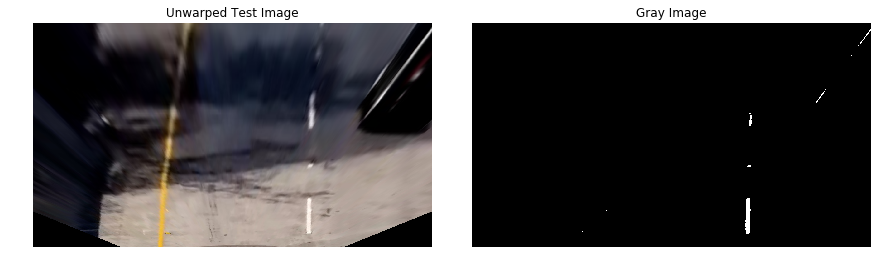

In [382]:
def apply10(threshMin, threshMax):
    
    testImageUnwrapGrayThresh = grayThresh(testImageUnwrap, (threshMin, threshMax))
    plotImages([testImageUnwrap, testImageUnwrapGrayThresh], ['Unwarped Test Image', 'Gray Image'], cmap='gray')
    
# interact(apply10, threshMin=(0,255), threshMax=(0,255))
apply10(201, 255)

# plotImages([testImageUnwrap, testImageUnwrap[:,:,1]], ['Unwarped Test Image', 'G Channel Image'], cmap='gray')

### Combine all Thresholds

In [285]:
def combineThresh(image):
    
    imageUndistort = undistort(image, cameraMatrix, distCoeffs)
    
    imageUnwrap, M, Minv = unwrap(imageUndistort)
    
    gradx = absSobelThresh(imageUnwrap, 'x', 24, 66)
    grady = absSobelThresh(imageUnwrap, 'y', 24, 66)
    magBinary = magSobelThresh(imageUnwrap, 31, (40, 115))
    dirBinary = dirSobelThresh(imageUnwrap, 21, (0, 1.48))
    
    combinedSobel = np.zeros_like(dirBinary)
    combinedSobel[(gradx == 1) & (magBinary == 1)] = 1
    
    # apply4(24, 66, 31, 40, 115, 21, 0, 1.48)
    
    imageUnwrapSThresh = HLS_SThresh(imageUnwrap, (113, 255))
    imageUnwrapHThresh = HLS_HThresh(imageUnwrap, (19, 90))
    imageUnwrapLThresh = HLS_LThresh(imageUnwrap, (220, 255))
    
    imageUnwrapRThresh = RGB_RThresh(imageUnwrap, (223, 255))
    imageUnwrapGThresh = RGB_GThresh(imageUnwrap, (199, 255))
    
    imageUnwrapGrayThresh = grayThresh(imageUnwrap, (201, 255))
    
    combined = np.zeros_like(imageUnwrapGrayThresh)
    combined[
        (imageUnwrapLThresh == 1)
#         | (imageUnwrapSThresh == 1)
#         | (imageUnwrapHThresh == 1)
        | (combinedSobel == 1)
        | (imageUnwrapRThresh == 1)
        | (imageUnwrapGThresh == 1)
        | (imageUnwrapGrayThresh == 1)
    ] = 1
    return combined, Minv

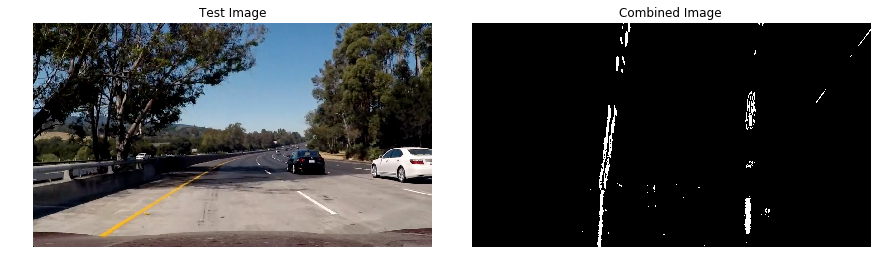

In [383]:
testImageCombined, Minv = combineThresh(testImage)

plotImages([testImage, testImageCombined], ['Test Image', 'Combined Image'], cmap='gray')

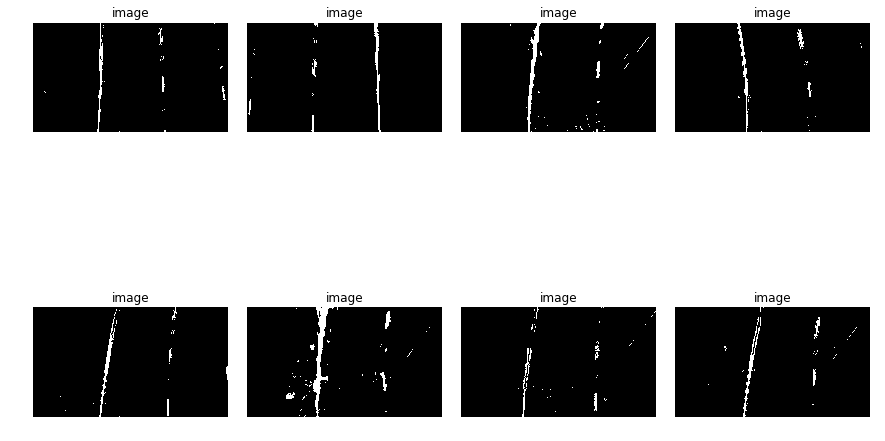

In [287]:
images = glob.glob('./test_images/*.jpg')
images = [combineThresh(cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB))[0] for image in images]
titles = ['image' for image in images]

plotImages(images, titles, cmap='gray')

### Sliding Window Plot

In [254]:
def slidingWindowPlot(image):
    
    hist = np.sum(image[(2*image.shape[0])//3:,:], axis=0)
    mid = np.int(image.shape[1]//2)
    quad = np.int(mid//2)
    
    leftBase = np.argmax(hist[quad:mid]) + quad
    rightBase = np.argmax(hist[mid:mid+quad]) + mid
    
    nWindows = 10
    windowHeight = np.int(image.shape[0]/nWindows)
    windowWidth = 80
    
    nonzero = image.nonzero()
    nonzeroY = np.array(nonzero[0])
    nonzeroX = np.array(nonzero[1])
    
    leftCurrent = leftBase
    rightCurrent = rightBase
    
    # arrays to collect indices for poly fit
    leftIndices = []
    rightIndices = []
    
    # rectangles to draw on the image
    rectangles = []
    minpix = 40
    
    for i in range(nWindows):
        
        # get the rectangle
        windowYUp = image.shape[0] - i*windowHeight
        windowYDown = image.shape[0] - (i+1)*windowHeight
        windowXLeftLow = leftCurrent - windowWidth
        windowXLeftHigh = leftCurrent + windowWidth
        windowXRightLow = rightCurrent - windowWidth
        windowXRightHigh = rightCurrent + windowWidth
        rectangles.append((windowYUp, 
                           windowYDown, 
                           windowXLeftLow, 
                           windowXLeftHigh, 
                           windowXRightLow, 
                           windowXRightHigh))
        
        # find the nonzero bits inside the rectangle
        foundLeftIndices = ((nonzeroY >= windowYDown) 
                            & (nonzeroY < windowYUp) 
                            & (nonzeroX >= windowXLeftLow) 
                            & (nonzeroX < windowXLeftHigh)
                           ).nonzero()[0]
        foundRightIndices = ((nonzeroY >= windowYDown) 
                            & (nonzeroY < windowYUp) 
                            & (nonzeroX >= windowXRightLow) 
                            & (nonzeroX < windowXRightHigh)
                            ).nonzero()[0]
        leftIndices.append(foundLeftIndices)
        rightIndices.append(foundRightIndices)
        
        # if enough bits were found, shift the rectangle
        if len(foundLeftIndices) > minpix:
            leftCurrent = np.int(np.mean(nonzeroX[foundLeftIndices]))
        if len(foundRightIndices) > minpix:
            rightCurrent = np.int(np.mean(nonzeroX[foundRightIndices]))
            
    # concatinate all the indices in array
    leftIndices = np.concatenate(leftIndices)
    rightIndices = np.concatenate(rightIndices)
    
    # get all the bits for the polyfit
    leftX = nonzeroX[leftIndices]
    leftY = nonzeroY[leftIndices]
    rightX = nonzeroX[rightIndices]
    rightY = nonzeroY[rightIndices]
    
    leftPoly = np.polyfit(leftY, leftX, 2) if len(leftX) != 0 else None
    rightPoly = np.polyfit(rightY, rightX, 2) if len(rightX) != 0 else None
    
    return leftPoly, rightPoly, leftIndices, rightIndices, rectangles, hist

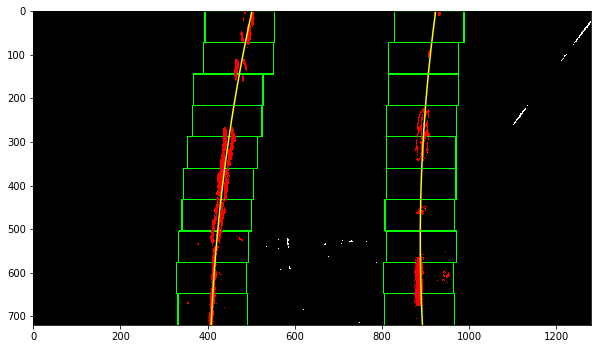

In [385]:
leftPoly, rightPoly, leftIndices, rightIndices, rectangles, hist = slidingWindowPlot(testImageCombined)

# create image to draw on
outputImage = np.uint8(np.dstack((testImageCombined, testImageCombined, testImageCombined))*255)
plotY = np.linspace(0, testImageCombined.shape[0]-1, testImageCombined.shape[0])

leftPlotX = leftPoly[0]*plotY**2 + leftPoly[1]*plotY + leftPoly[2]
rightPlotX = rightPoly[0]*plotY**2 + rightPoly[1]*plotY + rightPoly[2]

# draw the rectangles
for rectangle in rectangles:
    cv2.rectangle(outputImage, (rectangle[2], rectangle[0]), (rectangle[3], rectangle[1]), (0, 255, 0), 2)
    cv2.rectangle(outputImage, (rectangle[4], rectangle[0]), (rectangle[5], rectangle[1]), (0, 255, 0), 2)
    
nonzero = testImageCombined.nonzero()
nonzeroY = np.array(nonzero[0])
nonzeroX = np.array(nonzero[1])
outputImage[nonzeroY[leftIndices], nonzeroX[leftIndices]] = [255, 0, 0]
outputImage[nonzeroY[rightIndices], nonzeroX[rightIndices]] = [255, 0, 0]
plt.figure(figsize=(10, 6))
plt.imshow(outputImage)
plt.plot(leftPlotX, plotY, color='yellow')
plt.plot(rightPlotX, plotY, color='yellow')

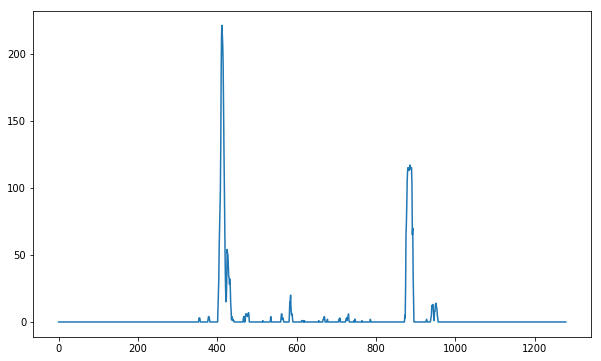

In [387]:
plt.figure(figsize=(10, 6))
plt.plot(hist)

### Radius of Curvature and Distance from the Center Lane

#### Radius of Curvature 

In [306]:
def radiusCurv(image, leftIndices, rightIndices):
    
    # Define conversions in x and y from pixels space to meters
    yMetPerPix = 30/720
    xMetPerPix = 3.7/700
    
    h = image.shape[0]
    plotY = np.linspace(0, h-1, h)
    yBottom = np.max(plotY)
    
    # the left and right bits
    nonzero = image.nonzero()
    nonzeroY = np.array(nonzero[0])
    nonzeroX = np.array(nonzero[1])
    leftX = nonzeroX[leftIndices]
    leftY = nonzeroY[leftIndices]
    rightX = nonzeroX[rightIndices]
    rightY = nonzeroY[rightIndices]
    
    leftCurvRadius, rightCurvRadius = None, None
    
    # fit the curviture
    if len(leftX) != 0 and len(rightX) != 0:
        leftPolyCr = np.polyfit(leftY*yMetPerPix, leftX*xMetPerPix, 2)
        rightPolyCr = np.polyfit(rightY*yMetPerPix, rightX*xMetPerPix, 2)
        
        # calculate the radii of curvature for both lanes
        leftCurvRadius = (
            (1 + (
                2*leftPolyCr[0]*yBottom*yMetPerPix + leftPolyCr[1])**2 
            )**1.5
        ) / np.absolute(2*leftPolyCr[0])
        rightCurvRadius = (
            (1 + (
                2*rightPolyCr[0]*yBottom*yMetPerPix + rightPolyCr[1])**2 
            )**1.5
        ) / np.absolute(2*rightPolyCr[0])
    
    return leftCurvRadius, rightCurvRadius

#### Distance from Center Lane

In [307]:
def centerDist(image, leftPoly, rightPoly):
    
    xMetPerPix = 3.7/700
    centerDist = None
    
    if leftPoly is not None and rightPoly is not None:
        
        # the car is in the center of the frame
        carPos = image.shape[1]/2
        leftBottom = leftPoly[0]*image.shape[0]**2 + leftPoly[1]*image.shape[0] + leftPoly[2]
        rightBottom = rightPoly[0]*image.shape[0]**2 + rightPoly[1]*image.shape[0] + rightPoly[2]
        lanesPos = (leftBottom + rightBottom) / 2
        centerDist = (carPos - lanesPos) * xMetPerPix
        
    return centerDist

In [308]:
leftCurvRadius, rightCurvRadius = radiusCurv(testImageCombined, leftIndices, rightIndices)
centDist = centerDist(testImageCombined, leftPoly, rightPoly)

print(leftCurvRadius, rightCurvRadius)
print(centDist)

1360.24477368 1273.87802486
-0.0548354939926


### Draw the poly fits on the image and fill in between the lanes

In [352]:
def drawAndFill(orgImage, binImage, leftPoly, rightPoly, Minv):
    
    if leftPoly is None or rightPoly is None:
        return orgImage
    
    # get new image to draw on
    newImage = np.copy(orgImage)
    drawImage = np.zeros_like(binImage).astype(np.uint8)
    drawImage = np.dstack((drawImage, drawImage, drawImage))
    
    # get the plots
    h, w = binImage.shape
    plotY = np.linspace(0, h-1, h)
    leftPlotX = leftPoly[0]*plotY**2 + leftPoly[1]*plotY + leftPoly[2]
    rightPlotX = rightPoly[0]*plotY**2 + rightPoly[1]*plotY + rightPoly[2]
    
    # get the points to fill
    leftPoints = np.array(
        [np.transpose(
            np.vstack([leftPlotX, plotY])
        )]
    )
    rightPoints = np.array(
        [np.flipud(
            np.transpose(
                np.vstack([rightPlotX, plotY])
            )
        )]
    )
    fillPoint = np.hstack((leftPoints, rightPoints))
    
    # draw the lines and fill
    cv2.fillPoly(drawImage, np.int_([fillPoint]), (0,255, 0))
    cv2.polylines(drawImage, np.int32([leftPoints]), isClosed=False, color=(255, 0, 0), thickness=15)
    cv2.polylines(drawImage, np.int32([rightPoints]), isClosed=False, color=(255, 0, 0), thickness=15)
    
    # unwrap the draw image and add it to the new image
    drawImage = cv2.warpPerspective(drawImage, Minv, (w, h))
    newImage = cv2.addWeighted(newImage, 1, drawImage, 0.5, 0)
    
    return newImage

[  1.20738601e-04  -2.16604533e-01   5.01445982e+02] [  1.28926632e-04  -1.34978847e-01   9.23016160e+02]


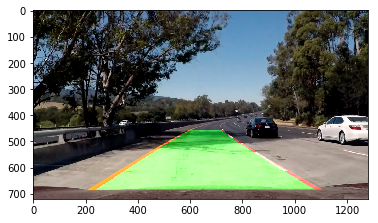

In [389]:
testImageLines = drawAndFill(testImage, testImageCombined, leftPoly, rightPoly, Minv)
print(leftPoly, rightPoly)
plt.imshow(testImageLines)

### Add the Radius of Curvature and Distance from Center to Image

In [296]:
def drawInfo(image, radiusCurv, centerDist):
    
    newImage = np.copy(image)
    h = newImage.shape[0]
    
    # get the test for direction
    directionText = 'right' if centerDist > 0 else 'left'
    centerDist = abs(centerDist)
    
    # define the texts
    curvText = 'Radius of Curvature: {:04.2f}'.format(radiusCurv) + 'm'
    distText = 'Distance from Center: {:04.2f}'.format(centerDist) + 'm ' + directionText + ' of center'
    
    # 'draw' the texts
    font = cv2.FONT_HERSHEY_TRIPLEX
    cv2.putText(newImage, curvText, (40, 70), font, 1.5, (0, 255, 0), 2, cv2.LINE_AA)
    cv2.putText(newImage, distText, (40, 120), font, 1.5, (0, 255, 0), 2, cv2.LINE_AA)
    
    return newImage

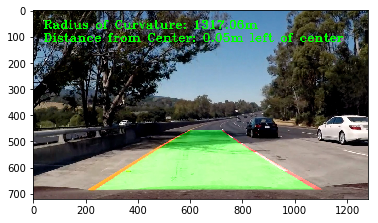

In [391]:
testImageFinal = drawInfo(testImageLines, (leftCurvRadius + rightCurvRadius)/2, centDist)
plt.imshow(testImageFinal)
plt.savefig('unwrap.png')

In [354]:
class Store():
    
    def __init__(self):
        self.avgPoly = None
        self.diff = np.array([0,0,0], dtype='float')
        self.prevPolys = []
        self.numPolys = 20
        
    def addFit(self, poly):
        
        if poly is not None:
            self.diff = abs(poly - self.avgPoly) if self.avgPoly is not None else self.diff
            if (
                self.diff[0] <= 0.001 
                and self.diff[1] <= 1.0 
                and self.diff[2] <= 100.0
            ) or len(self.prevPolys) == 0:
                
                self.prevPolys.append(poly)
                if len(self.prevPolys) > self.numPolys:
                    del self.prevPolys[0]
                self.avgPoly = np.average(self.prevPolys, axis=0)

### Add the steps into one function

In [351]:
def processImage(image):
    
    newImage = np.copy(image)
#     cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)
    binImage, Minv = combineThresh(newImage)
    
    leftPoly, rightPoly, leftIndices, rightIndices, _, _ = slidingWindowPlot(binImage)
    leftStore.addFit(leftPoly)
    rightStore.addFit(rightPoly)
    leftPoly = leftStore.avgPoly if leftStore.avgPoly is not None else leftPoly
    rightPoly = rightStore.avgPoly if rightStore.avgPoly is not None else rightPoly
    
    newImage = drawAndFill(newImage, binImage, leftPoly, rightPoly, Minv)
    
    leftCurvRadius, rightCurvRadius = radiusCurv(binImage, leftIndices, rightIndices)
    centDist = centerDist(binImage, leftPoly, rightPoly)
    newImage = drawInfo(newImage, (leftCurvRadius + rightCurvRadius)/2, centDist)
    
    return newImage

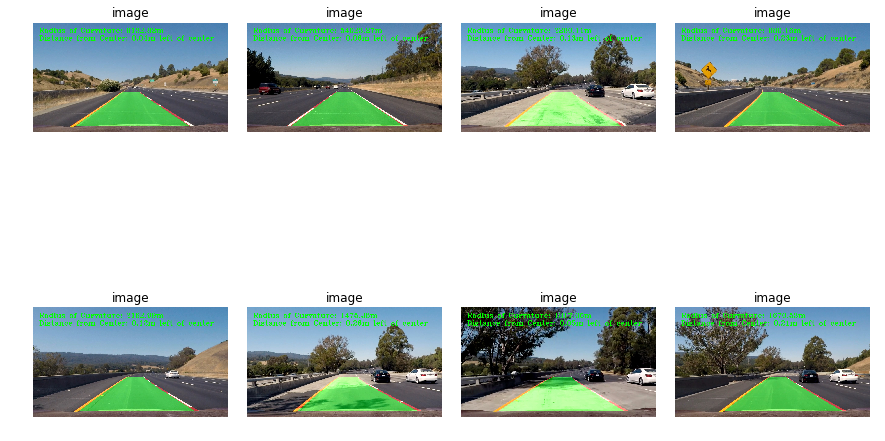

In [299]:
images = glob.glob('./test_images/*.jpg')
images = [processImage(cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)) for image in images]
titles = ['image' for image in images]

plotImages(images, titles, cmap='gray')

### Process Video

In [396]:
leftStore = Store()
rightStore = Store()
videoOutputName = 'videoOutput.mp4'
videoInput = VideoFileClip('project_video.mp4')
processedVideo = videoInput.fl_image(processImage)
%time processedVideo.write_videofile(videoOutputName, audio=False)

[MoviePy] >>>> Building video videoOutput.mp4
[MoviePy] Writing video videoOutput.mp4


100%|█████████▉| 1260/1261 [13:46<00:00,  1.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: videoOutput.mp4 

CPU times: user 13min 23s, sys: 2min 28s, total: 15min 52s
Wall time: 13min 48s
